In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
# Read CSV Data
df = pd.read_csv("../data/cumulative.csv")
# Remove unnecessary features
df = df.drop(columns=["rowid", "kepid", "kepoi_name", "kepler_name", "koi_pdisposition", "koi_score",\
    "koi_tce_delivname"])
# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')
# Drop the null rows
df = df.dropna()
# Preview "df"
df.head()

,koi_disposition,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,CONFIRMED,0,0,0,0,9.488036,2.775000e-05,-2.775000e-05,170.538750,0.002160,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,CONFIRMED,0,0,0,0,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,FALSE POSITIVE,0,1,0,0,19.899140,1.494000e-05,-1.494000e-05,175.850252,0.000581,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,FALSE POSITIVE,0,1,0,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,CONFIRMED,0,0,0,0,2.525592,3.761000e-06,-3.761000e-06,171.595550,0.001130,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


## <font color="navy">Optimize Correlation Threshold to Remove Functionally Redundant Features</font>
<i><font color="sky blue"><strong>Optimization was applied in random forest (rf) model as rf does not require the distribution pattern of data<strong></font></i>

In [3]:
# Column to be used as label
target = df["koi_disposition"]    

# Transform categorical labels to numerical
from sklearn.preprocessing import LabelEncoder
target_encoder = LabelEncoder().fit(target.values)
encd_target = target_encoder.transform(target.values)
    
# One-hot encoding labels
from tensorflow.keras.utils import to_categorical
encd_target_categ = to_categorical(encd_target)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# List to hold correlation threshold (corr_thold) to be tested in Random Forest model
corr_thold_list = range(20, 100, 5)

# Library to hold score info. for each corr_thold
corr_thold_results = {
    "corr_thold": [],
    "number of features": [],
    "testing score": []
}

# Iterate for each corr_thold
for corr_thold in corr_thold_list:
    
    # Columns to be used as features
    features = df.drop("koi_disposition", axis=1)
    # List for names of all columns from "features"
    cols = features.columns
    # List for names of functionally redudant columns to be deleted
    col_del = []
    
    for i in range(len(cols)):
        '''
        If B and C are both closely correlated with A, appending cols[j] rather than cols[i] will delete
        both B and C with no exception even if they are not correlated to each other at all, which might
        compromise our model.
        It has been tested that deleting "cols[i]" will yield a better score given the same correlation
        threshold.
        '''
        [col_del.append(cols[i]) for j in range(i) if (abs(features[cols[i]].corr(features[cols[j]]))\
            > corr_thold / 100) and (cols[i] not in col_del)]

    # Delete functionally redundant columns
    features = features.drop(columns=col_del)
    
    # Split date into train and test    
    X_train, X_test, y_train, y_test = train_test_split(features, encd_target_categ, random_state=8)
    
    # Use MinMaxScaler for normalization as we are dealing with distance metrics        
    X_scaler_mms = MinMaxScaler().fit(X_train)
    X_train_scaled_mms = X_scaler_mms.transform(X_train)
    X_test_scaled_mms = X_scaler_mms.transform(X_test)
       
    # Create random forest classifier
    rf = RandomForestClassifier(n_estimators=200)
    rf = rf.fit(X_train_scaled_mms, y_train)

    # Append results to "corr_thold_results"
    corr_thold_results["corr_thold"].append(corr_thold / 100)
    corr_thold_results["number of features"].append(features.shape[1])
    corr_thold_results["testing score"].append(rf.score(X_test_scaled_mms, y_test))

C:\Users\kouda\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\kouda\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\kouda\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\kouda\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\kouda\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, fl

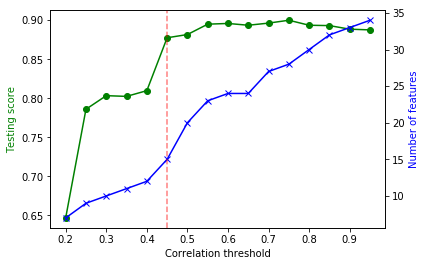

In [53]:
# Make plot for "testing score" and "number of features"
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(corr_thold_results["corr_thold"], corr_thold_results["testing score"], marker='o', color="g")
ax2.plot(corr_thold_results["corr_thold"], corr_thold_results["number of features"],\
    marker="x", color="b")

plt.axvline(x=0.45, linestyle='dashed', c="r", alpha=0.5)

ax1.set_xlabel("Correlation threshold")
ax1.set_ylabel("Testing score", color="g")
ax2.set_ylabel("Number of features", color="b")

# Save figure
# https://stackoverflow.com/questions/37427362/plt-show-shows-full-graph-but-savefig-is-cropping-the-image
plt.savefig("../figures/correlation_threshold.png", bbox_inches='tight', dpi=300)

plt.show()

###### Based on the chart, <span style="background-color:red; color:white">correlation threshold at 0.45 with as few as 15 features</span> still retains the potential for optimized prediction

## <font color="navy">Prepare Features and Labels for Machine Learning Models</font>

In [6]:
# Set corr_thold at 0.45
corr_thold = 45

# Features used thereafter to build ML models (before deleting functionally redundant columns)
features = df.drop("koi_disposition", axis=1)

# List for column names to be deleted due to high correlation with others
col_del = []
# List for names of all columns from "features"
cols = features.columns

for i in range(len(cols)):
    # Append name of features (cols[i]) to "col_del" if high correlated column is found
    [col_del.append(cols[i]) for j in range(i) if abs(features[cols[i]].corr(features[cols[j]]))\
        > corr_thold / 100]

# Delete functionally redundant columns
features = features.drop(columns=col_del)

# View names of remaining columns in features
features.columns

Index(['koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_period',
       'koi_impact', 'koi_impact_err1', 'koi_duration', 'koi_depth',
       'koi_depth_err1', 'koi_teq', 'koi_insol', 'koi_tce_plnt_num',
       'koi_steff', 'ra', 'dec'],
      dtype='object')

In [7]:
# Iterate for each column in features
for col in features.columns:
    
    # Check for skewness and kurtosis
    skewness = stats.describe(features[col])[4]
    kurtosis = stats.describe(features[col])[5]
    
    # Print out column info if either skewness or kurtosis is larger than 3
    if (skewness > 3) or (kurtosis > 3):    
        print("*" * 10)
        print(f"feature name: {col}")
        print(f"skewness: {skewness}")
        print(f"kurtosis: {kurtosis}")

**********
feature name: koi_period
skewness: 2.9096056442850604
kurtosis: 8.575707227778738
**********
feature name: koi_impact
skewness: 24.545626819012853
kurtosis: 654.292256814103
**********
feature name: koi_impact_err1
skewness: 6.312551243046779
kurtosis: 40.330434371786815
**********
feature name: koi_duration
skewness: 6.142732763305333
kurtosis: 69.88306228640944
**********
feature name: koi_depth
skewness: 5.339789447449275
kurtosis: 39.95195255565689
**********
feature name: koi_depth_err1
skewness: 90.88380242228578
kurtosis: 8398.884284599475
**********
feature name: koi_teq
skewness: 3.4534017756543443
kurtosis: 27.91764996090529
**********
feature name: koi_insol
skewness: 52.04085840580866
kurtosis: 3129.058646282767
**********
feature name: koi_tce_plnt_num
skewness: 3.650882561012579
kurtosis: 16.94099602738316
**********
feature name: koi_steff
skewness: 0.7542120521681619
kurtosis: 8.074889842710324


###### Based on skewness and kurtosis study, there are two thirds columns in features whose data are not normally distributed (>3). In considering data distribution, we will use random forest, SVM, KNN, and Neural Network models thereafter

In [8]:
# Save "features" as csv file
features.to_csv("../data/features_and_label_cleaned.csv", index=False, header=True)

In [9]:
# Set up train and test data for all machine learning models to be built in this project
# Split date into train and test
X_train, X_test, y_train, y_test = train_test_split(features, encd_target_categ, random_state=8)

In [10]:
# Regression models will not be used due to data distribution
# MinMaxScaler is preferred over StandardScaler for scaling features
# In this project, StandardScaler scored exactly the same as MinMaxScaler at corr_thold=0.45
X_scaler = MinMaxScaler().fit(X_train)

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

C:\Users\kouda\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


## <font color="navy">Machine Learn Models</font>

In [11]:
from numpy.random import seed
seed(8)

In [12]:
# Dict to hold all info. with regard to machine learning models (RF, SVM, KNN, NN)
model_dict = {
    "rf": {},
    "svm": {},
    "knn": {},
    "nn": {}
}

In [13]:
from sklearn.svm import SVC   # Support Vector Machine (SVM) model
from sklearn.neighbors import KNeighborsClassifier   # K Nearest Neighbors (KNN) model

# Classifier for RF, SVM, and KNN models
model_dict["rf"]["classifier"] = RandomForestClassifier(random_state=8)
model_dict["svm"]["classifier"] = SVC(random_state=8)
model_dict["knn"]["classifier"] = KNeighborsClassifier()

In [14]:
# .......... FUNCTION TO BUILD CLASSIFIER FOR NEURAL NETWORK MODEL .......... #
def build_classifier(optimizer, units):
    classifier = Sequential()

    # Hidden layer
    classifier.add(Dense(units=units,
                         activation="relu",
                         input_dim=len(features.columns)                         
                        ))
    # Output layer
    classifier.add(Dense(units=3,
                         activation="softmax"
                        ))
    # Compile the neural work
    classifier.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    
    return classifier
# .......... FUNCTION ENDS .......... #

In [15]:
from tensorflow.keras.models import Sequential   # Neural Network model
from tensorflow.keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

# Wrap Keras model so it can be used by scikit-learn
model_dict["nn"]["classifier"] = KerasClassifier(build_fn=build_classifier, verbose=0)

Using TensorFlow backend.


In [16]:
# Set up tuning parameters for each classifier
model_dict["rf"]["param_grid"] = {
    'n_estimators': [50, 200, 500],
    'criterion': ["gini", "entropy"],
    'max_features': ["sqrt", "log2"]
}

model_dict["svm"]["param_grid"] = {
    'C': [0.1, 1, 10],
    'kernel': ["linear", "poly", "rbf", "sigmoid"],
    'gamma': [0.0001, 0.001, 0.01]
}

model_dict["knn"]["param_grid"] = {
    'n_neighbors': list(range(1, 20, 2)),
    'weights': ["uniform", "distance"],
    'algorithm': ["ball_tree", "kd_tree", "brute"]
}

'''
SCREENING FOR NUMBER OF HIDDEN NEURONS IN NEURAL NETWORK MODEL

According to the ref:
https://stats.stackexchange.com/questions/181/
    how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw
1. Layer of hidden nodes is set to 1
2. Number of input neurons is the length of features (15)
3. Number of hidden neurons (hn) is supposed to be selected between 3 (output) and 15 (input), exclusive
4. Number of output neurons is 3
'''

model_dict["nn"]["param_grid"] = {
    'batch_size': [5, 20],
    'nb_epoch': [10, 50],
    'optimizer': ["adam", "rmsprop"],
    'units': list(range(3, len(features.columns), 3))
}

In [17]:
# Create GridSearch estimator for hyperparameter tuning of the model
from sklearn.model_selection import GridSearchCV

In [18]:
import pickle

# DataFrame used to showcase predictions by different models
comparison = pd.DataFrame()

for model in list(model_dict.keys()):

    # Print current iterated model
    print(f"Current iterated model: {model.upper()}")
    
    # Estimator
    model_dict[model]["estimator"] = GridSearchCV(
        model_dict[model]["classifier"], 
        model_dict[model]["param_grid"],
    )
    
    # SVM model can not take One-Hot-encoding label
    if model == "svm":
        y_train_im = np.argmax(y_train, axis=-1) # Tempprary y_train and y_test used for fitting the model
        y_test_im = np.argmax(y_test, axis=-1) 
    else:
        y_train_im = y_train 
        y_test_im = y_test    
        
    # Fit model using grid search estimator
    if model == "nn":
        model_dict[model]["estimator"].fit(X_train_scaled, y_train_im, shuffle=True)
    else:
        model_dict[model]["estimator"].fit(X_train_scaled, y_train_im)
        
    # Inverse labels in "y_test"
    # https://stackoverflow.com/questions/54143458/
        # convert-categorical-data-back-to-numbers-using-keras-utils-to-categorical
    y_test_invr = target_encoder.inverse_transform(np.argmax(y_test, axis=-1))
    
    # Predict "y_pred"
    y_pred = model_dict[model]["estimator"].predict(X_test_scaled)
    
    # Inverse labels in "y_pred"
    # Note that different from Sequential predict, which always returns the same datatype of "y_train_im"
    # "predict" for KerasClassifier("nn") returns CLASS prediction for given test data 
        # (like "predict_classes for Sequential")
    if (model == "svm") or (model == "nn"):
        y_pred_invr = target_encoder.inverse_transform(y_pred)
    else:
        y_pred_invr = target_encoder.inverse_transform(np.argmax(y_pred, axis=-1))
    
    # Append inversed "y_test" and "y_pred" to "comparison" DataFrame
    comparison[f"{model}_test"] = y_test_invr
    comparison[f"{model}_pred"] = y_pred_invr
    
    # Scores
    # Note that KerasClassifier also has "score" (mean accuracy)
    training_score = model_dict[model]["estimator"].score(X_train_scaled, y_train_im)
    testing_score = model_dict[model]["estimator"].score(X_test_scaled, y_test_im)
    model_dict[model]["test_eval"] = {"training_score": training_score, "testing_score": testing_score}
    
    # Generate classification report
    model_dict[model]["classif_rpt"] = classification_report(y_test_invr, y_pred_invr)
    
    # Save models
    if model == "nn":
        # save the classifier
        model_dict[model]["estimator"].best_estimator_.model.save(f"../models/kepler_{model}_model.h5")     
    else:  
        # Save model as .pkl file (documentation)
        with open(f"../models/kepler_{model}_model.pkl", 'wb') as fid:
            pickle.dump(model_dict[model]["estimator"], fid)  

    # Print complete information
    print(f"{model.upper()} iteration DONE!!!")

C:\Users\kouda\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Current iterated model: RF
RF iteration DONE!!!
Current iterated model: SVM


C:\Users\kouda\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


SVM iteration DONE!!!
Current iterated model: KNN


C:\Users\kouda\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\kouda\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
W0720 20:28:58.516965   824 deprecation.py:506] From C:\Users\kouda\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


KNN iteration DONE!!!
Current iterated model: NN
NN iteration DONE!!!


## <font color="navy">Evaluation and Comparison of Machine Learn Models</font>

In [19]:
# Lists for training and testing scores of ML models
y_axis_training = []
y_axis_testing = []

# Append scores to corresponding lists
[y_axis_training.append(model_dict[model]["test_eval"]["training_score"])\
    for model in list(model_dict.keys())]
[y_axis_testing.append(model_dict[model]["test_eval"]["testing_score"])\
    for model in list(model_dict.keys())]

# Print scores
print(f"training score: {y_axis_training}")
print(f"testing score: {y_axis_testing}")

training score: [1.0, 0.786062824031717, 0.8276913693199146, 0.7433669]
testing score: [0.8810612991765783, 0.7964318389752973, 0.7676120768526989, 0.75434583]


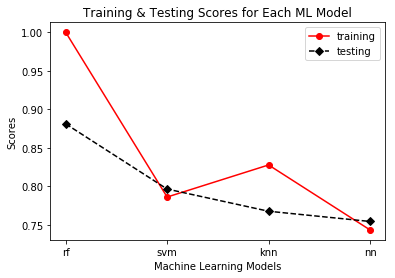

In [54]:
# Make line-scatter plot for training and testing scores of different ML models
plt.plot(list(range(1, 5)), y_axis_training, '-o', c='r', label="training")
plt.plot(list(range(1, 5)), y_axis_testing, '--D', c='k', label="testing")

# Create title
plt.title("Training & Testing Scores for Each ML Model")

# Create labels for x and y axes
plt.xlabel("Machine Learning Models")
plt.ylabel("Scores")

# Create x-ticks
plt.xticks(list(range(1, 5)), list(model_dict.keys()))

# Create legend
plt.legend(loc="best")

# Save figure
plt.savefig("../figures/training_testing_scores.png", bbox_inches='tight', dpi=300)

plt.show()

###### It can be told from the above plot that among all ML models evaluated, <span style="background-color:red; color:white">random forest (rf)</span> exhibited the highest training and testing scores, indicating the best predicting performance

In [74]:
precision_dict = {"CANDIDATE": [], "CONFIRMED": [], "FALSE POSITIVE": []}
recall_dict = {"CANDIDATE": [], "CONFIRMED": [], "FALSE POSITIVE": []}
f1_score_dict = {"CANDIDATE": [], "CONFIRMED": [], "FALSE POSITIVE": []}

for model in list(model_dict.keys()):
    
    classif = model_dict[model]["classif_rpt"].split(" ")
    
    while "" in classif:
        classif.remove("")
        
    precision_dict["CANDIDATE"].append(float(classif[5]))
    recall_dict["CANDIDATE"].append(float(classif[6]))
    f1_score_dict["CANDIDATE"].append(float(classif[7])) 
    precision_dict["CONFIRMED"].append(float(classif[10]))
    recall_dict["CONFIRMED"].append(float(classif[11]))
    f1_score_dict["CONFIRMED"].append(float(classif[12]))
    precision_dict["FALSE POSITIVE"].append(float(classif[15]))
    recall_dict["FALSE POSITIVE"].append(float(classif[16]))
    f1_score_dict["FALSE POSITIVE"].append(float(classif[17]))     

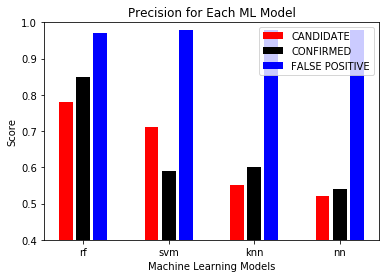

In [80]:
# Make bar plot for precision of predicion made using test datafor different ML models
plt.bar(list(range(1, 17, 5)), precision_dict["CANDIDATE"], color='r', label="CANDIDATE")
plt.bar(list(range(2, 18, 5)), precision_dict["CONFIRMED"], color='k', label="CONFIRMED")
plt.bar(list(range(3, 19, 5)), precision_dict["FALSE POSITIVE"], color='b', label="FALSE POSITIVE")

# Create title
plt.title("Precision for Each ML Model")

# Create labels for x and y axes
plt.xlabel("Machine Learning Models")
plt.ylabel("Score")

# Create x-ticks
plt.xticks(list(range(2, 18, 5)), list(model_dict.keys()))

# Create legend
plt.legend(loc=1)

# Set limits on y axis
plt.ylim(0.4, 1)

# Save figure
plt.savefig("../figures/test_precision.png", bbox_inches='tight', dpi=300)

plt.show()

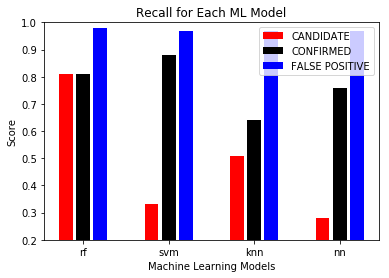

In [81]:
# Make bar plot for recall of predicion made using test datafor different ML models
plt.bar(list(range(1, 17, 5)), recall_dict["CANDIDATE"], color='r', label="CANDIDATE")
plt.bar(list(range(2, 18, 5)), recall_dict["CONFIRMED"], color='k', label="CONFIRMED")
plt.bar(list(range(3, 19, 5)), recall_dict["FALSE POSITIVE"], color='b', label="FALSE POSITIVE")

# Create title
plt.title("Recall for Each ML Model")

# Create labels for x and y axes
plt.xlabel("Machine Learning Models")
plt.ylabel("Score")

# Create x-ticks
plt.xticks(list(range(2, 18, 5)), list(model_dict.keys()))

# Create legend
plt.legend(loc=1)

# Set limits on y axis
plt.ylim(0.2, 1)

# Save figure
plt.savefig("../figures/test_recall.png", bbox_inches='tight', dpi=300)

plt.show()

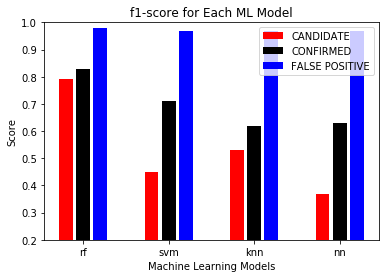

In [87]:
# Make bar plot for f1-score of predicion made using test datafor different ML models
plt.bar(list(range(1, 17, 5)), f1_score_dict["CANDIDATE"], color='r', label="CANDIDATE")
plt.bar(list(range(2, 18, 5)), f1_score_dict["CONFIRMED"], color='k', label="CONFIRMED")
plt.bar(list(range(3, 19, 5)), f1_score_dict["FALSE POSITIVE"], color='b', label="FALSE POSITIVE")

# Create title
plt.title("f1-score for Each ML Model")

# Create labels for x and y axes
plt.xlabel("Machine Learning Models")
plt.ylabel("Score")

# Create x-ticks
plt.xticks(list(range(2, 18, 5)), list(model_dict.keys()))

# Create legend
plt.legend(loc=1)

# Set limits on y axis
plt.ylim(0.2, 1)

# Save figure
plt.savefig("../figures/test_f1_score.png", bbox_inches='tight', dpi=300)

plt.show()

###### It can be tell from the above plots that all ML models are very good at isolating cohorts that are proven to be false positive. Among all ML models evaluated, <span style="background-color:red; color:white">random forest (rf)</span> is superior over the rest in terms of both precision and re-call. 

In [96]:
# Delete redundant "test" columns from "comparison"
comparison.drop(["svm_test", "knn_test", "nn_test"], axis=1, inplace=True)

# Rename columns in "comparison"
comparison = comparison.rename(columns={
    "rf_test": "Features_test",
    "rf_pred": "Features_pred_RF",
    "svm_pred": "Features_pred_SVM",
    "knn_pred": "Features_pred_KNN",
    "nn_pred": "Features_pred_NN"    
})

In [97]:
# Preview "comparison"
comparison.head()

,Features_test,Features_pred_RF,Features_pred_SVM,Features_pred_KNN,Features_pred_NN
0,FALSE POSITIVE,FALSE POSITIVE,FALSE POSITIVE,FALSE POSITIVE,FALSE POSITIVE
1,FALSE POSITIVE,FALSE POSITIVE,FALSE POSITIVE,FALSE POSITIVE,FALSE POSITIVE
2,CONFIRMED,CONFIRMED,CONFIRMED,CONFIRMED,CONFIRMED
3,CANDIDATE,CANDIDATE,CONFIRMED,CONFIRMED,CONFIRMED
4,FALSE POSITIVE,FALSE POSITIVE,FALSE POSITIVE,FALSE POSITIVE,FALSE POSITIVE


In [117]:
# List to hold wrong prediction model names in "comparison"
pred_check = []

for i in range(len(comparison)):
    # List to hold wrong prediction model names for each row
    list_im = []
    # Iterate through column names of each ML model
    for name in list(comparison.columns)[1:]:
        # Abbr. for ML model names
        model = name.split("_")[-1]
        # Append names of ML models that have made wrong prediction in the row
        if comparison["Features_test"][i] != comparison[name][i]:
            list_im.append(model) 
    # Append "list_im" to "pred_check at the end of each iteration"
    if len(list_im) > 0:
        pred_check.append(list_im)
    else:
        pred_check.append("")

In [116]:
# Add new column to "comparison" to display ML model names for making wrong prediction in each row
comparison["Wrong Prediction"] = pred_check

# Preview "comparison"
comparison.head(20)

,Features_test,Features_pred_RF,Features_pred_SVM,Features_pred_KNN,Features_pred_NN,Wrong Prediction
0,FALSE POSITIVE,FALSE POSITIVE,FALSE POSITIVE,FALSE POSITIVE,FALSE POSITIVE,
1,FALSE POSITIVE,FALSE POSITIVE,FALSE POSITIVE,FALSE POSITIVE,FALSE POSITIVE,
2,CONFIRMED,CONFIRMED,CONFIRMED,CONFIRMED,CONFIRMED,
3,CANDIDATE,CANDIDATE,CONFIRMED,CONFIRMED,CONFIRMED,"[SVM, KNN, NN]"
4,FALSE POSITIVE,FALSE POSITIVE,FALSE POSITIVE,FALSE POSITIVE,FALSE POSITIVE,
5,CONFIRMED,CONFIRMED,CONFIRMED,CONFIRMED,CONFIRMED,
6,CANDIDATE,CANDIDATE,CONFIRMED,CONFIRMED,CONFIRMED,"[SVM, KNN, NN]"
7,FALSE POSITIVE,FALSE POSITIVE,FALSE POSITIVE,FALSE POSITIVE,FALSE POSITIVE,
8,FALSE POSITIVE,FALSE POSITIVE,FALSE POSITIVE,FALSE POSITIVE,FALSE POSITIVE,
9,FALSE POSITIVE,CANDIDATE,CANDIDATE,CANDIDATE,CONFIRMED,"[RF, SVM, KNN, NN]"


###### As can be easily seen from the table, RF shows up the least among all ML models on "Wrong Prediction" column. Taken all evaluation and comparison made above, <span style="background-color:red; color:white">random forest (rf)</span> is the most promising ML model built in this project